In [1]:
!nvidia-smi

Sun Apr  9 08:11:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

https://github.com/bnsreenu/python_for_microscopists/blob/master/076-077-078-Unet_nuclei_tutorial.py

In [3]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [55]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import normalize
from sklearn.model_selection import train_test_split

seed = 42
np.random.seed = seed

In [160]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
  #Build the model
  inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

  #Contraction path
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
  
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
  
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
  
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path 
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = tf.keras.layers.Dropout(0.2)(c6)
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
  
  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.Dropout(0.2)(c7)
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
  
  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
  
  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
  
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [161]:
# cp -r /content/drive/MyDrive/dent.zip -d /content
# !unzip -q /content/dent.zip

In [197]:
SIZE = 256

image_path = '/content/dent/train/image'
mask_path = '/content/dent/train/label'

image_dataset = []
mask_dataset = []

In [198]:
images = os.listdir(image_path)
print('total images',len(images))

for i, image in enumerate(images):
  path = os.path.join(image_path,image)
  # img = cv2.imread(path,0)
  img = cv2.imread(path)
  img = cv2.resize(img,(SIZE,SIZE),interpolation = cv2.INTER_AREA)
  img = img/255.0
  image_dataset.append(img)

total images 41


In [199]:
masks = os.listdir(mask_path)
print('total masks',len(masks))

for i, mask in enumerate(masks):
  path = os.path.join(mask_path,mask)
  # img = cv2.imread(path,0)
  img = cv2.imread(path,0)
  img = cv2.resize(img,(SIZE,SIZE),interpolation = cv2.INTER_AREA)
  mask_dataset.append(img)

total masks 41


In [200]:
# image_dataset = np.expand_dims(normalize(np.array(image_dataset),axis=1),3)
image_dataset = np.array(image_dataset)
print(image_dataset.shape)

(41, 256, 256, 3)


In [201]:
mask_dataset = np.expand_dims((np.array(mask_dataset)),3)/255.
print(mask_dataset.shape)

(41, 256, 256, 1)


In [202]:
X_train,X_test,y_train,y_test = train_test_split(image_dataset,mask_dataset,test_size = 0.2)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (32, 256, 256, 3)
X_test (9, 256, 256, 3)
y_train (32, 256, 256, 1)
y_test (9, 256, 256, 1)


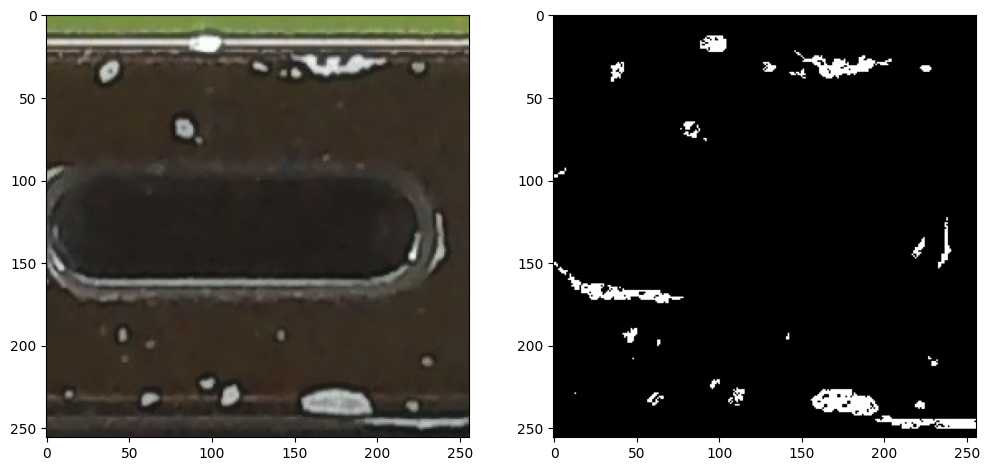

In [205]:
image_number = random.randint(0,len(X_train))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number],(256,256,3)),cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number],(256,256)),cmap='gray')

In [206]:
IMG_HEIGHT = SIZE
IMG_WIDTH = SIZE
IMG_CHANNELS = 3

In [242]:
model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [243]:
history = model.fit(X_train,y_train,
                    batch_size= 12,
                    verbose=2, # 0,1,2
                    epochs=300,
                    validation_data = (X_test,y_test),
                    shuffle=False
                    )

Epoch 1/300
3/3 - 46s - loss: 0.6913 - accuracy: 0.6315 - val_loss: 0.6834 - val_accuracy: 0.9183 - 46s/epoch - 15s/step
Epoch 2/300
3/3 - 0s - loss: 0.6617 - accuracy: 0.8845 - val_loss: 0.4664 - val_accuracy: 0.9145 - 401ms/epoch - 134ms/step
Epoch 3/300
3/3 - 0s - loss: 0.4574 - accuracy: 0.8792 - val_loss: 0.4116 - val_accuracy: 0.9156 - 434ms/epoch - 145ms/step
Epoch 4/300
3/3 - 0s - loss: 0.3761 - accuracy: 0.8963 - val_loss: 0.3754 - val_accuracy: 0.9155 - 392ms/epoch - 131ms/step
Epoch 5/300
3/3 - 0s - loss: 0.2939 - accuracy: 0.8966 - val_loss: 0.2157 - val_accuracy: 0.9155 - 432ms/epoch - 144ms/step
Epoch 6/300
3/3 - 0s - loss: 0.3085 - accuracy: 0.8971 - val_loss: 0.3383 - val_accuracy: 0.9155 - 387ms/epoch - 129ms/step
Epoch 7/300
3/3 - 0s - loss: 0.2895 - accuracy: 0.8977 - val_loss: 0.2505 - val_accuracy: 0.9163 - 377ms/epoch - 126ms/step
Epoch 8/300
3/3 - 0s - loss: 0.2537 - accuracy: 0.8981 - val_loss: 0.2039 - val_accuracy: 0.9170 - 378ms/epoch - 126ms/step
Epoch 9/300

In [244]:
# evaluate the model
_,acc = model.evaluate(X_test,y_test)
print('Accuracy=',(acc*100.0),'%')

1/1 [==============================] - 0s 56ms/step - loss: 0.1100 - accuracy: 0.9348
Accuracy= 93.47703456878662 %


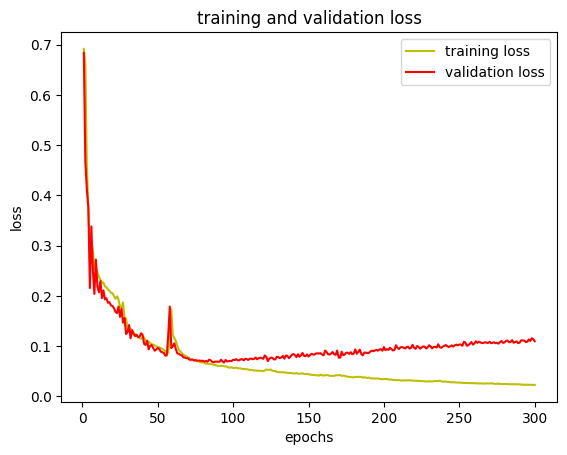

In [245]:
# plot the training and validation accuracy an loss each epochs
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs =range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label='training loss')
plt.plot(epochs,val_loss,'r',label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

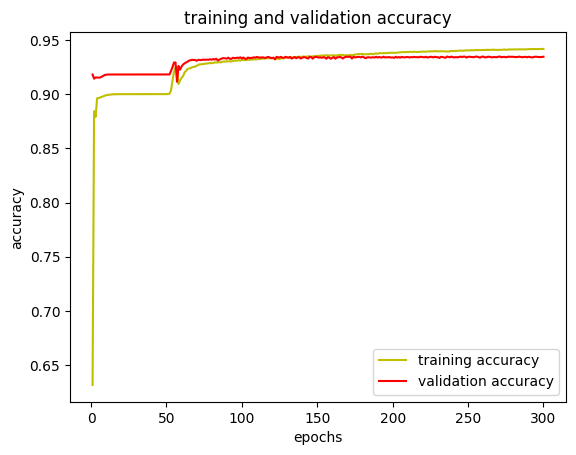

In [246]:
# plot the training and validation accuracy an loss each epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs =range(1,len(loss)+1)
plt.plot(epochs,acc,'y',label='training accuracy')
plt.plot(epochs,val_acc,'r',label='validation accuracy')
plt.title('training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [247]:
#IOU
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.3

intersection = np.logical_and(y_test,y_pred_thresholded)
union = np.logical_or(y_test,y_pred_thresholded)
iou_score = np.sum(intersection)/np.sum(union)
print('IoU score is',iou_score)

1/1 [==============================] - 0s 232ms/step
IoU score is 0.44044158233670655


(256, 256, 3)
(256, 256, 1)
(1, 256, 256, 3)
1/1 [==============================] - 0s 22ms/step
(256, 256, 1)


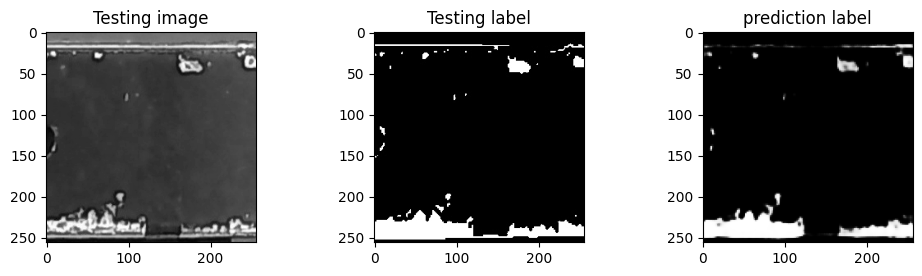

In [254]:
test_img_number = random.randint(0,len(X_test)-1)
test_img = X_test[test_img_number]
print(test_img.shape)
ground_truth = y_test[test_img_number]
print(ground_truth.shape)
test_img_input = np.expand_dims(test_img,0)
print(test_img_input.shape)
prediction = model.predict(test_img_input)[0]
print(prediction.shape)

plt.figure(figsize=(12,6))
plt.subplot(231)
plt.title('Testing image')
plt.imshow(test_img[:,:,0],cmap='gray')
plt.subplot(232)
plt.title('Testing label')
plt.imshow(ground_truth[:,:,0],cmap='gray')
plt.subplot(233)
plt.title('prediction label')
plt.imshow(prediction,cmap='gray')